In [ ]:
from google.colab import drive
drive.mount("/content/drive")

JSON_PATH = "/content/drive/MyDrive/3788741.json"
OUT_DIR   = "/content/drive/MyDrive/leverkusen/frames_out"
MAX_PLOTS = 12  # set None to export all frames


Mounted at /content/drive


In [ ]:
import json, os
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle, Circle

os.makedirs(OUT_DIR, exist_ok=True)

# --- tiny pitch helper (StatsBomb coords: 0..120 x, 0..80 y) ---
def draw_pitch(ax):
    ax.set_xlim(0, 120); ax.set_ylim(0, 80)
    ax.add_patch(Rectangle((0,0), 120, 80, fill=False, lw=1.5))
    # penalty areas
    ax.add_patch(Rectangle((0, 18), 18, 44, fill=False, lw=1))
    ax.add_patch(Rectangle((102, 18), 18, 44, fill=False, lw=1))
    # six-yard boxes
    ax.add_patch(Rectangle((0, 30), 6, 20, fill=False, lw=1))
    ax.add_patch(Rectangle((114, 30), 6, 20, fill=False, lw=1))
    # halfway + center circle
    ax.plot([60,60], [0,80], color="black", lw=1)
    ax.add_patch(Circle((60,40), 10, fill=False, lw=1))
    ax.set_aspect('equal'); ax.set_xticks([]); ax.set_yticks([])

# --- load JSON (array of 360 frame objects) ---
with open(JSON_PATH, "r", encoding="utf-8") as f:
    frames = json.load(f)

print(f"Loaded {len(frames)} frames from {JSON_PATH}")

# --- plotting loop ---
limit = (MAX_PLOTS if MAX_PLOTS is not None else len(frames))

for i, fr in enumerate(frames[:limit]):
    ev_id = fr.get("event_uuid", f"idx_{i}")
    vis = fr.get("visible_area", []) or []
    ff = fr.get("freeze_frame", []) or []

    fig, ax = plt.subplots(figsize=(7, 4.7))
    draw_pitch(ax)

    # draw visible area polygon
    if len(vis) >= 6 and len(vis) % 2 == 0:
        pts = [(vis[j], vis[j+1]) for j in range(0, len(vis), 2)]
        poly = Polygon(pts, closed=True, facecolor="none", edgecolor="tab:blue", lw=1.5, alpha=0.9)
        ax.add_patch(poly)
        ax.fill([p[0] for p in pts], [p[1] for p in pts], alpha=0.08, color="tab:blue")

    # plot players
    # - actor: star
    # - teammates: circles
    # - opponents: triangles
    # - keepers get a black edge
    for p in ff:
        loc = p.get("location", None)
        if not (isinstance(loc, list) and len(loc) >= 2):
            continue
        x, y = loc[:2]
        if x is None or y is None:
            continue

        is_tm = bool(p.get("teammate", False))
        is_actor = bool(p.get("actor", False))
        is_keeper = bool(p.get("keeper", False))

        if is_actor:
            m, c, size = "*", "tab:orange", 180
        else:
            if is_tm:
                m, c = "o", "tab:green"
            else:
                m, c = "^", "tab:red"
            size = 70

        edge = "black" if is_keeper else "none"
        ax.scatter([x],[y], s=size, marker=m, color=c, edgecolors=edge, linewidths=1.2, zorder=5)

    # legend handles
    import matplotlib.lines as mlines
    lg = [
        mlines.Line2D([], [], color="tab:blue", lw=2, label="visible_area"),
        plt.Line2D([], [], marker="*", linestyle="None", markersize=10, color="tab:orange", label="actor"),
        plt.Line2D([], [], marker="o", linestyle="None", markersize=7, color="tab:green", label="teammate"),
        plt.Line2D([], [], marker="^", linestyle="None", markersize=7, color="tab:red", label="opponent"),
        plt.Line2D([], [], marker="o", linestyle="None", markersize=7, markerfacecolor="none",
                   markeredgecolor="black", color="black", label="keeper (edge)"),
    ]
    ax.legend(handles=lg, loc="lower center", bbox_to_anchor=(0.5, -0.02), ncol=5, frameon=False)
    ax.set_title(f"Event {ev_id}")

    out = os.path.join(OUT_DIR, f"{i:03d}_{ev_id}.png")
    fig.tight_layout()
    fig.savefig(out, dpi=150)
    plt.close(fig)

print(f"Saved images to: {OUT_DIR}")


Loaded 3370 frames from /content/drive/MyDrive/3788741.json
Saved images to: /content/drive/MyDrive/leverkusen/frames_out


PNG count: 12


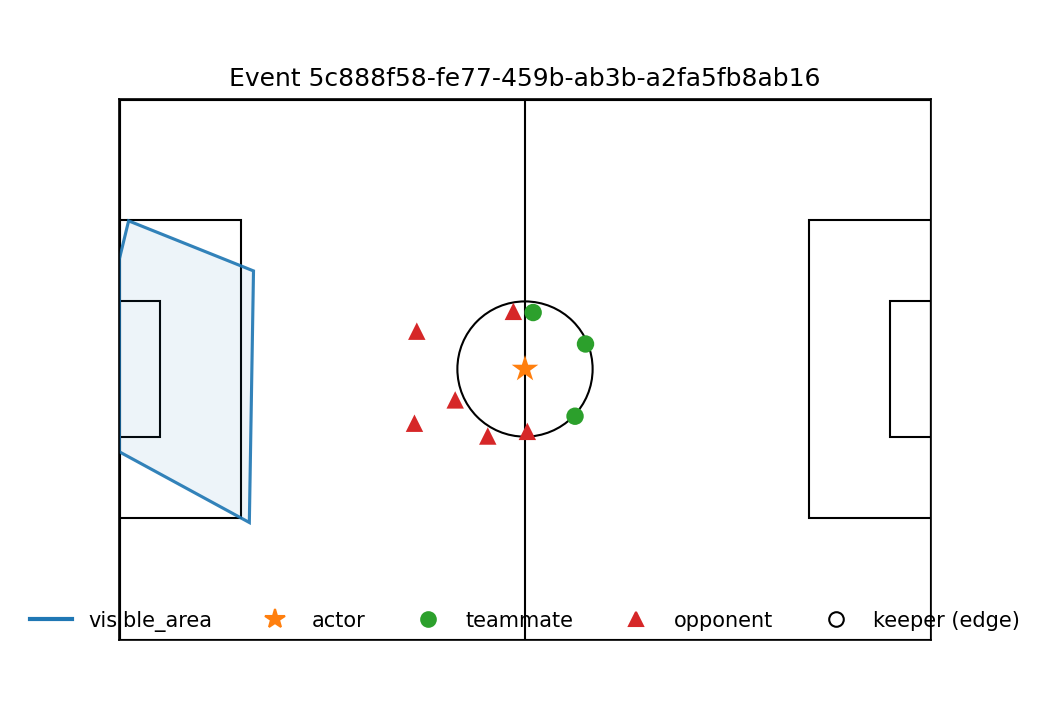

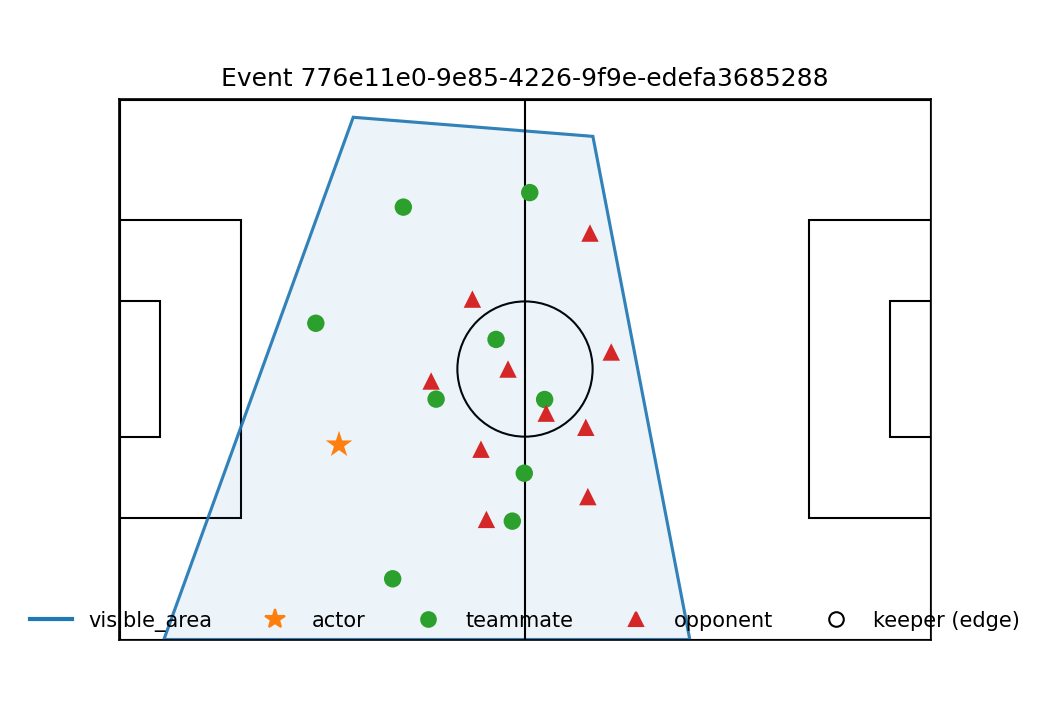

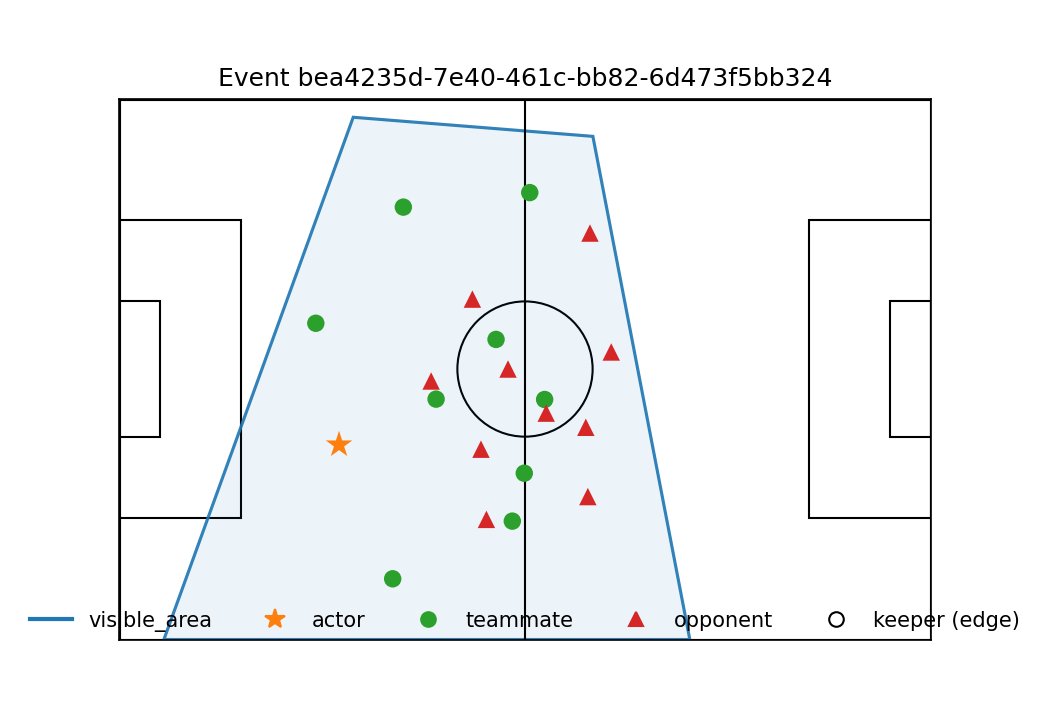

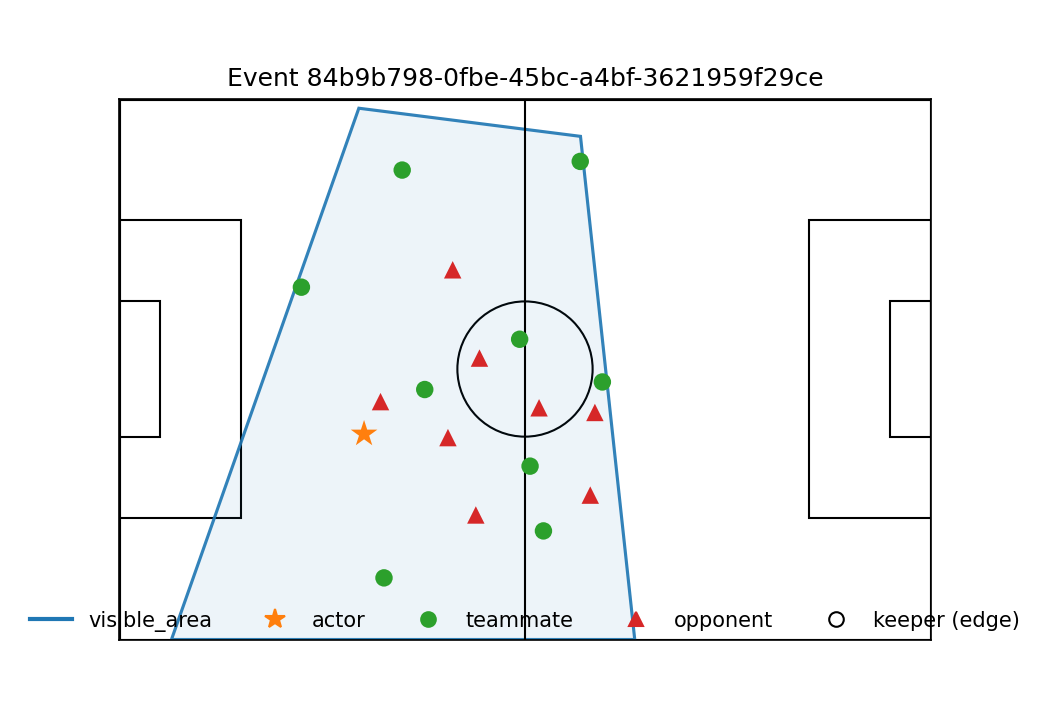

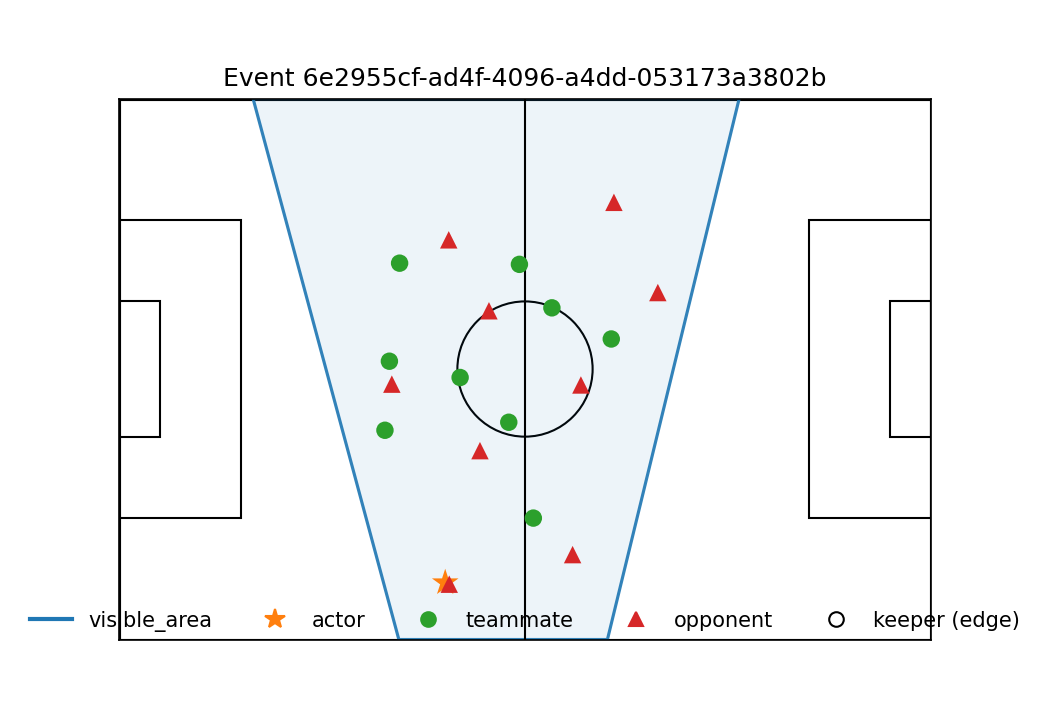

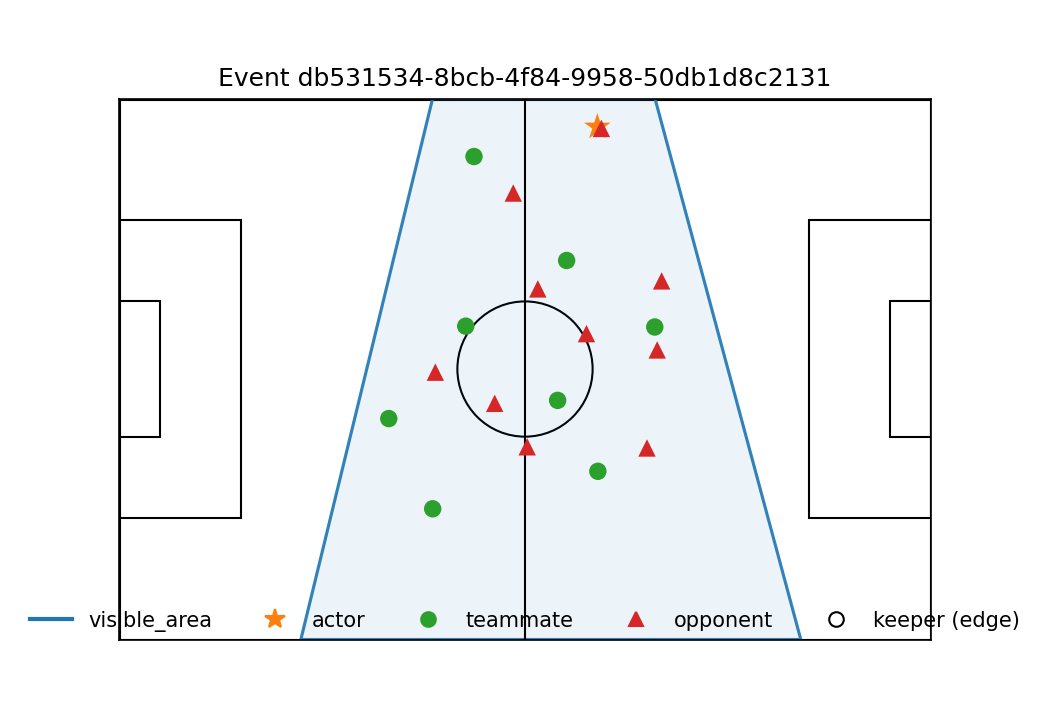

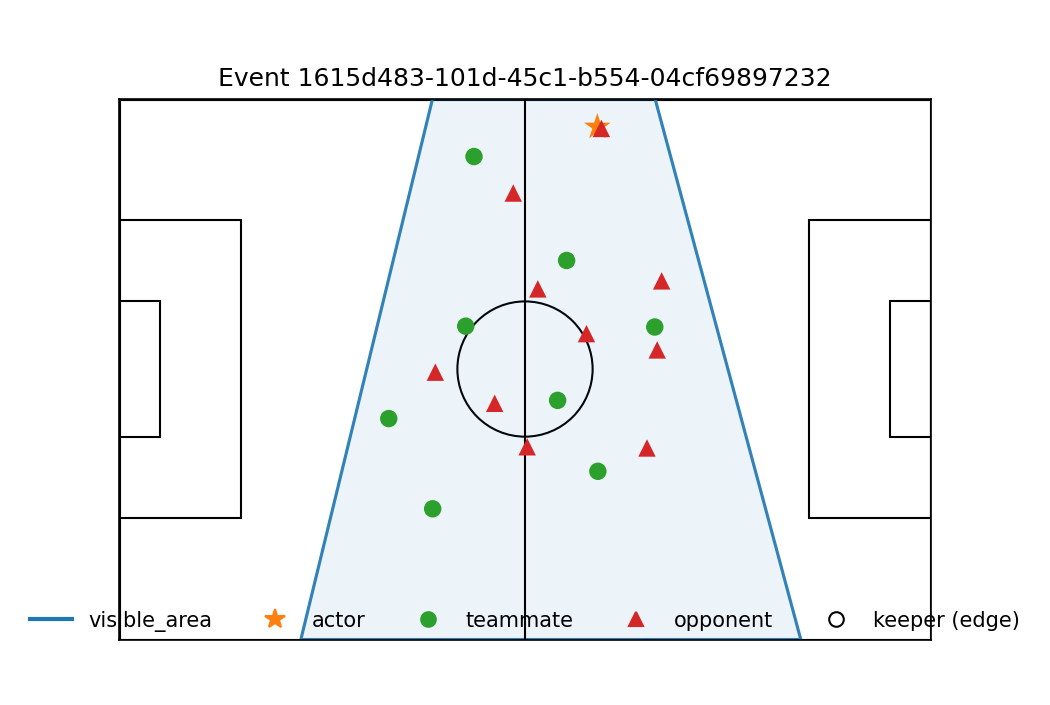

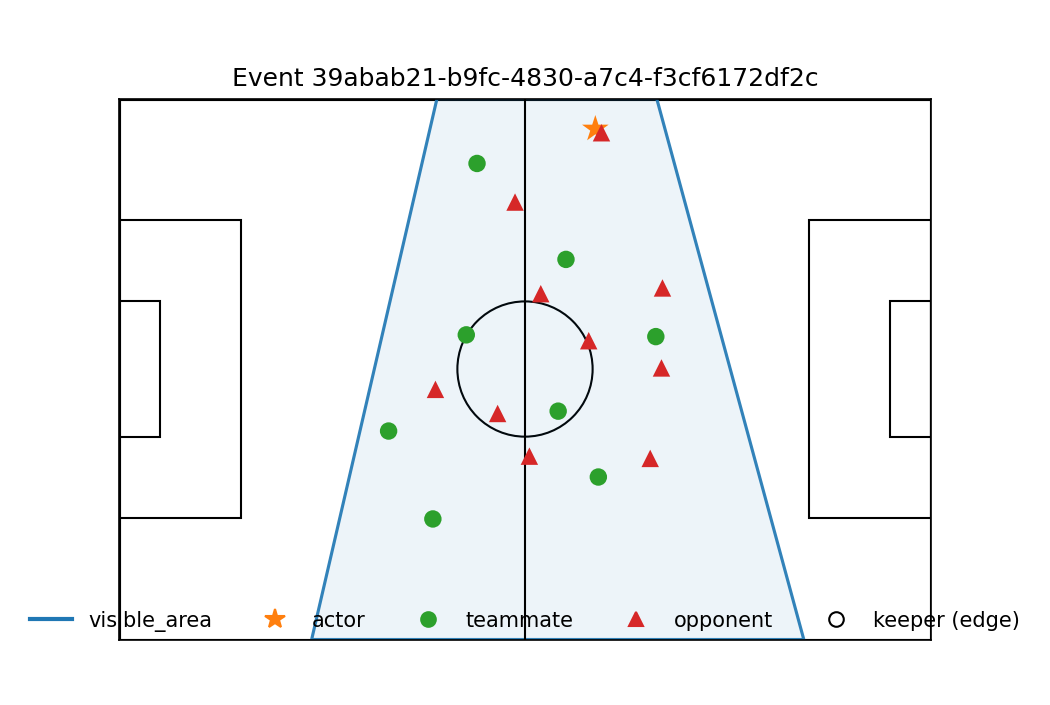

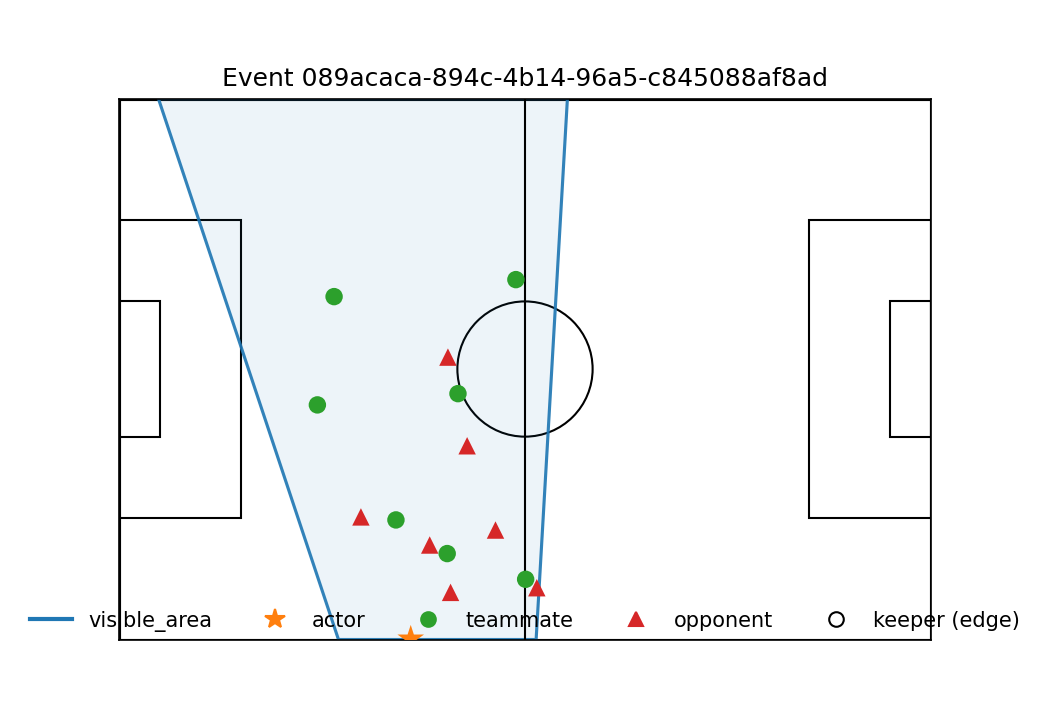

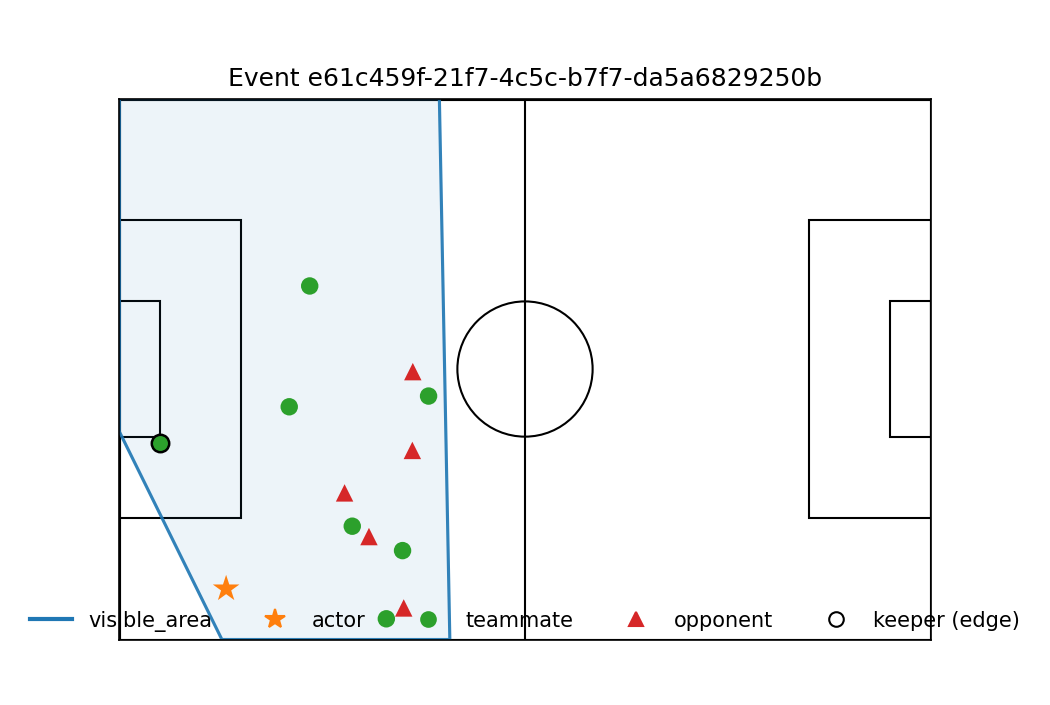

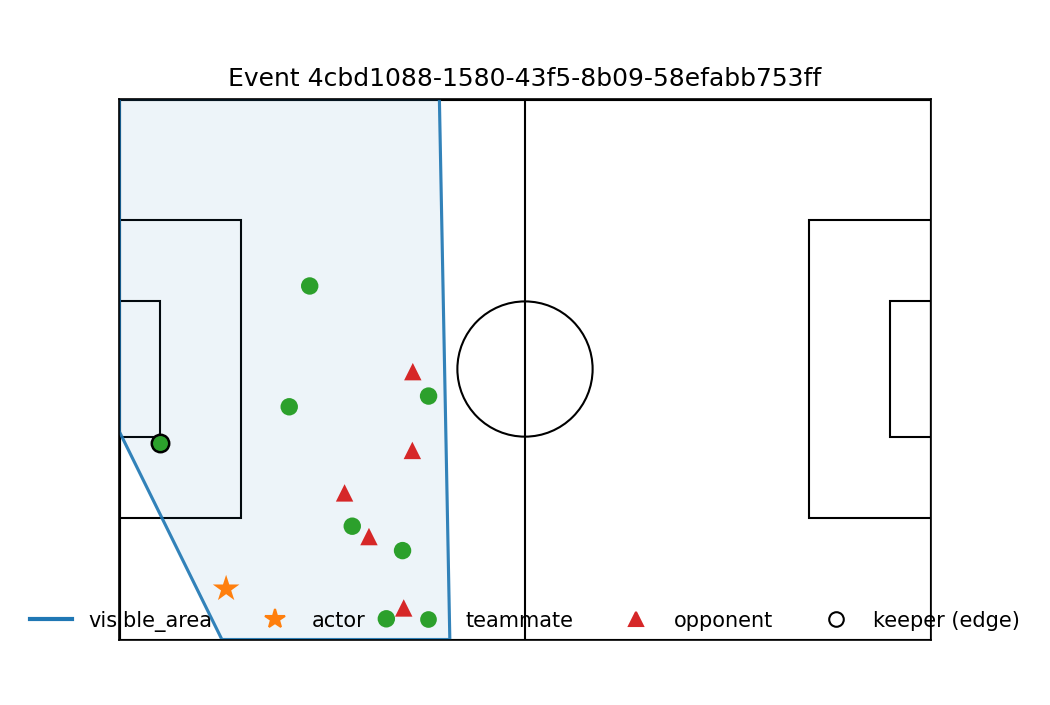

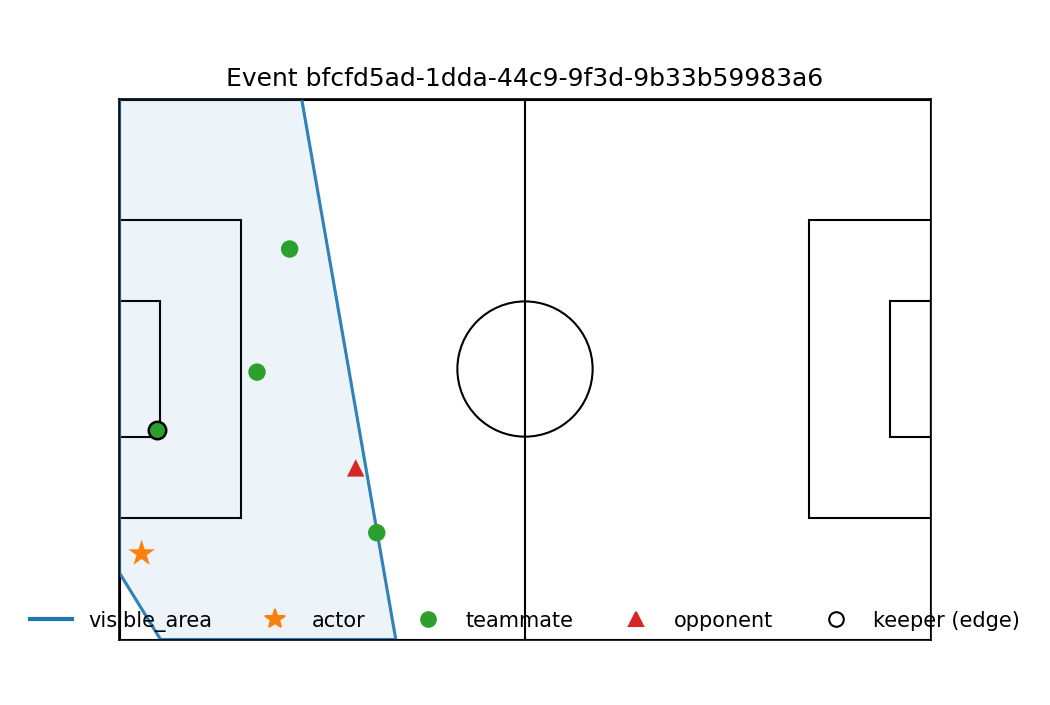

In [ ]:
from IPython.display import Image, display
import glob, os

pngs = sorted(glob.glob(os.path.join(OUT_DIR, "*.png")))
print("PNG count:", len(pngs))

for fp in pngs[:12]:  # show first 12
    display(Image(filename=fp))
